In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import os
os.chdir("/home/zhzhou/GNN_E")
import numpy as np
import pandas as pd
import torch
from torch_geometric.loader import DataLoader
from math import ceil
from utils_models import *
from scripts.models import *
from GCN_models import *

/home/zhzhou/.conda/envs/GNN_E/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#data_path = 'data/processed/all_movies_labelled_13_single.csv'
data_path = '/home/dalai/GNN_E/data/processed/all_movies_labelled_13_single_balanced.csv'
df =  pd.read_csv(data_path, index_col=0)

In [3]:
df.head()

,Unnamed: 0.1,vindex,score,id,movie,timestamp_tr,label
0,0,0,-21.180140,1,0,0,-1
1,1,0,-14.295689,1,0,1,-1
2,2,0,-5.882564,1,0,2,-1
3,3,0,30.127113,1,0,3,-1
4,4,0,41.830845,1,0,4,-1


In [4]:
df_single = df[df.movie==9]

In [5]:
df_single.head()

,Unnamed: 0.1,vindex,score,id,movie,timestamp_tr,label
74802348,74802348,0,61.011930,1,9,0,-1
74802349,74802349,0,32.491920,1,9,1,-1
74802350,74802350,0,57.399090,1,9,2,-1
74802351,74802351,0,20.886257,1,9,3,-1
74802352,74802352,0,30.854342,1,9,4,-1


In [6]:
os.getcwd()

'/home/zhzhou/GNN_E'

In [7]:
from pickle5 import pickle as pkl
with open("/home/dalai/GNN_E/data/raw/labels/run_onsets.pkl", "rb") as file:
    delta_time = pkl.load(file)

In [8]:
from pickle5 import pickle as pkl
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
df_train,_, df_test = df_train, df_val, df_test = split_train_val_test_horizontally(
        df_single, 
        percentage_val=0, #0 to not have nay val set
        path_pickle_delay="/home/dalai/GNN_E/data/raw/labels/run_onsets.pkl",
        path_movie_title_mapping="data/raw/labels/category_mapping_movies.csv", 
        tr_len=1.3
    )
dataset_train = DatasetEmo(df_train, device=DEVICE,initial_adj_method='FN_edgeAttr_FC_window', node_feat="symmetricwindow")
dataset_test = DatasetEmo(df_test, device = DEVICE,initial_adj_method='FN_edgeAttr_FC_window', node_feat="symmetricwindow")

graphs_list_train = dataset_train.get_graphs_list()
graphs_list_test = dataset_test.get_graphs_list()



Movie: Superhero
  Start Time (TR)+4: 80
  Total Length (TR): 791
  Train End (TR): 712
  Validation End (TR): 712
  Movie End (TR): 871
Movies in this df: [9]


Processing 9 32: 100%|██████████| 347/347 [00:11<00:00, 31.19timepoint/s]


Movies in this df: [9]


Processing 9 32: 100%|██████████| 68/68 [00:01<00:00, 40.53timepoint/s]


In [9]:
from torch_geometric.loader import DataLoader
from math import ceil
batch_size = 16
train_loader = DataLoader(graphs_list_train, batch_size=batch_size, num_workers=4, persistent_workers=True)
test_loader = DataLoader(graphs_list_test, batch_size=batch_size, num_workers=4, persistent_workers=True)

num_batches_train = ceil(len(graphs_list_train) / batch_size)
num_batches_test = ceil(len(graphs_list_test) / batch_size)

print(f"There are {len(graphs_list_train)} graphs in the train set.")
print(f"There are {len(graphs_list_test)} graphs in the test set.")
print(f"N batches in train: {num_batches_train}")
print(f"N batches in test: {num_batches_test}")

There are 10334 graphs in the train set.
There are 1654 graphs in the test set.
N batches in train: 646
N batches in test: 104


In [10]:
graphs_list_test[0].edge_index

tensor([[113, 113, 113,  ..., 412, 413, 413],
        [114, 115, 116,  ..., 411, 411, 412]])

In [11]:
import networkx as nx
#edge_index = graphs_list_test[0].edge_index.numpy()
edge_index = graphs_list_test[0].edge_index.numpy()
edge_attr = graphs_list_test[0].edge_attr.numpy()
G = nx.Graph()

# Add edges with weights
for i in range(edge_index.shape[1]):
    u, v = edge_index[:, i]
    weight = 1 if graphs_list_test[0].edge_attr is not None else 0  # Default weight to 1 if edge_attr is not provided
    G.add_edge(u, v, weight=weight)
nx.diameter(G)

1

In [12]:
edge_index.shape

(2, 1560)

In [13]:
source = 113
target = 411
shortest_path = nx.shortest_path(G, source=source, target=target, weight='weight')
print(shortest_path)

[113, 411]


In [14]:
graphs_list_test[0].edge_index.shape

torch.Size([2, 1560])

In [15]:
from tqdm import tqdm
input_dim = 9 
hidden_dim1 = 128
hidden_dim2 = 64
output_dim = 13  # Number of classes
print(isinstance(SimpleGCN(9, 64,32, 13), nn.Module))
model = SimpleGCN(input_dim, hidden_dim1, hidden_dim2, output_dim).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
loss_fn = torch.nn.CrossEntropyLoss()
num_epochs = 1
# Training loop
torch.cuda.empty_cache()
model, results_dict = GCN_train(model=model, optimizer=optimizer, loss_fn=loss_fn, 
                                    train_loader=train_loader, test_loader=test_loader, device=DEVICE, num_epochs=10)


True


	Epoch 1/10, Loss: 2.7767588828370298, Train accuracy: 0.1043158505902845



	Epoch 1/10, Loss: 3.3222, test accuracy: 0.0895



	Epoch 2/10, Loss: 2.6814476185169753, Train accuracy: 0.13160441261854075



	Epoch 2/10, Loss: 4.0014, test accuracy: 0.0919



	Epoch 3/10, Loss: 2.668400657804389, Train accuracy: 0.12405651248306561



	Epoch 3/10, Loss: 3.5019, test accuracy: 0.1082



	Epoch 4/10, Loss: 2.5661886697952223, Train accuracy: 0.125895103541707



	Epoch 4/10, Loss: 4.1915, test accuracy: 0.1076



	Epoch 5/10, Loss: 2.6043465656023645, Train accuracy: 0.13721695374491968



	Epoch 5/10, Loss: 3.4024, test accuracy: 0.1227



	Epoch 6/10, Loss: 2.5263826059114085, Train accuracy: 0.1259918714921618



	Epoch 6/10, Loss: 3.4365, test accuracy: 0.1167



	Epoch 7/10, Loss: 2.5463290221919954, Train accuracy: 0.12531449583897813



	Epoch 7/10, Loss: 3.3311, test accuracy: 0.1245



	Epoch 8/10, Loss: 2.488755767744023, Train accuracy: 0.12841107025353202



	Epoch 8/10, Loss: 3.2573, test accuracy: 0.1227



	Epoch 9/10, Loss: 2.4959813142339513, Train accuracy: 0.1271530868976195



	Epoch 9/10, Loss: 3.3983, test accuracy: 0.1191



	Epoch 10/10, Loss: 2.507278174254178, Train accuracy: 0.12647571124443585



	Epoch 10/10, Loss: 3.2117, test accuracy: 0.1197



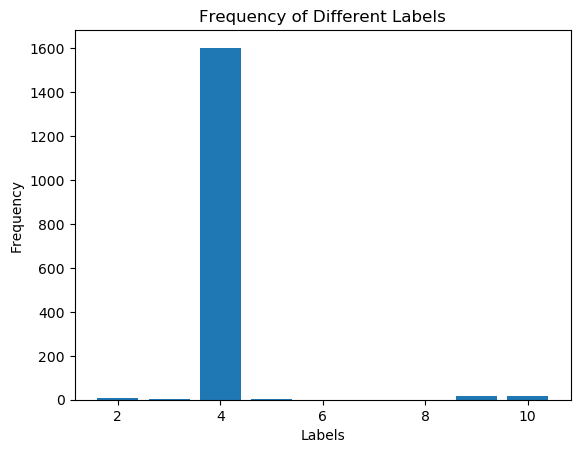

In [ ]:
all_labels = torch.cat(results_dict['best_prediction']).cpu().numpy()

# Calculate frequency of each unique label
unique_labels, counts = torch.unique(torch.tensor(all_labels), return_counts=True)

# Plot the frequency distribution
plt.bar(unique_labels.numpy(), counts.numpy())
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Frequency of Different Labels')
plt.show()

In [19]:
import matplotlib.pyplot as plt
predicted_label = []
for i in results_dict['best_prediction']:
    predicted_label = list(i)
predicted_label = [i.item() for i in predicted_label]

In [20]:
predicted_label

[4, 4, 4, 4, 4, 4]

In [17]:
file_name = 'GCNModel.pth'
torch.save(model.state_dict(), file_name)

In [ ]:
def test():
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0  # To keep track of the number of correct predictions
    total = 0    # To keep track of the total number of samples

    # No need for gradients during testing
    with torch.no_grad():
        progress_bar = tqdm(loader_test, desc="Testing", leave=False)
        for i, batch in enumerate(progress_bar):
            batch = batch.to(DEVICE)

            # Forward pass
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y)

            # Update total loss
            total_loss += loss.item()

            # Get the predicted class (index of the max logit)
            _, predicted = torch.max(out, dim=1)

            # Update the number of correct predictions and total samples
            correct += (predicted == batch.y).sum().item()
            print(predicted)
            print(batch.y)
            total += batch.y.size(0)

            # Update the progress bar with loss
            progress_bar.set_postfix({"Test Loss": predicted})

    # Calculate the average loss and accuracy
    avg_loss = total_loss / len(loader_test)
    accuracy = correct / total * 100  # Accuracy as a percentage

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")

    return avg_loss, accuracy

test()

In [20]:
print(predicted)

NameError: name 'predicted' is not defined

In [22]:
with open('GCNModel_result.pkl','wb') as f:
    pkl.dump(results_dict,f)